R environment

In [ ]:
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(data.table)
    library(Seurat)
    library(dplyr)
    library(tidyr)
    library(tibble)
    library(stringr)
    library(dittoSeq)
    library(patchwork)
    library(future)
    plan("multiprocess", workers = 8)
    options(future.globals.maxSize = 1000 * 1024^5)
    options(stringsAsFactors = FALSE)
    set.seed(123)
})

### Create Seurat Object

In [ ]:
reference.list <- readRDS('data/core_GBmap_seuratobj_list.rds')
gbm <- reference.list[['Ruiz2021']]

### Extract data from anndata object and input to Seurat

In [ ]:
use_condaenv("scarches")
sc <- import("scanpy")

In [ ]:
gbm_latent <- sc$read_h5ad("data/Ruiz2021_scacrhes_scanpy_clustering.h5ad")
gbm_latent

AnnData object with n_obs × n_vars = 39355 × 10
    obs: 'celltype_assigned', 'celltype_original', 'author', 'platform', 'method', 'gs_prediction_main', 'gs_prediction_detailed', 'patient', 'gender', 'cnv_filtered_geneset', 'cnv_full_geneset', 'leiden', 'predictions', 'orig_cell_types'
    uns: 'celltype_original_colors', 'leiden', 'leiden_colors', 'neighbors', 'orig_cell_types_colors', 'predictions_colors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

In [ ]:
# set embeddings
embedding <- gbm_latent$obsm["X_umap"]
rownames(embedding) <- colnames(gbm)
colnames(embedding) <- c("umap_1", "umap_2")
gbm[["umap"]] <- CreateDimReducObject(embedding, key = "umap_")

# set UMAP models
umap.new.model <- list()
umap.new.model$n_epochs <- 500
umap.new.model$alpha <-1
umap.new.model$method <- "umap"
umap.new.model$negative_sample_rate <- 5
umap.new.model$gamma <- 1
umap.new.model$approx_pow <- 0
umap.new.model$metric$cosine <- list()
umap.new.model$embedding <- gbm[["umap"]]@cell.embeddings
ab_param <- uwot:::find_ab_params(spread = 1, min_dist = 0.3)
umap.new.model$a <- ab_param["a"]
umap.new.model$b <- ab_param["b"]
gbm[["umap"]]@misc$model <- umap.new.model

Warning message:
“No assay specified, setting assay as RNA by default.”


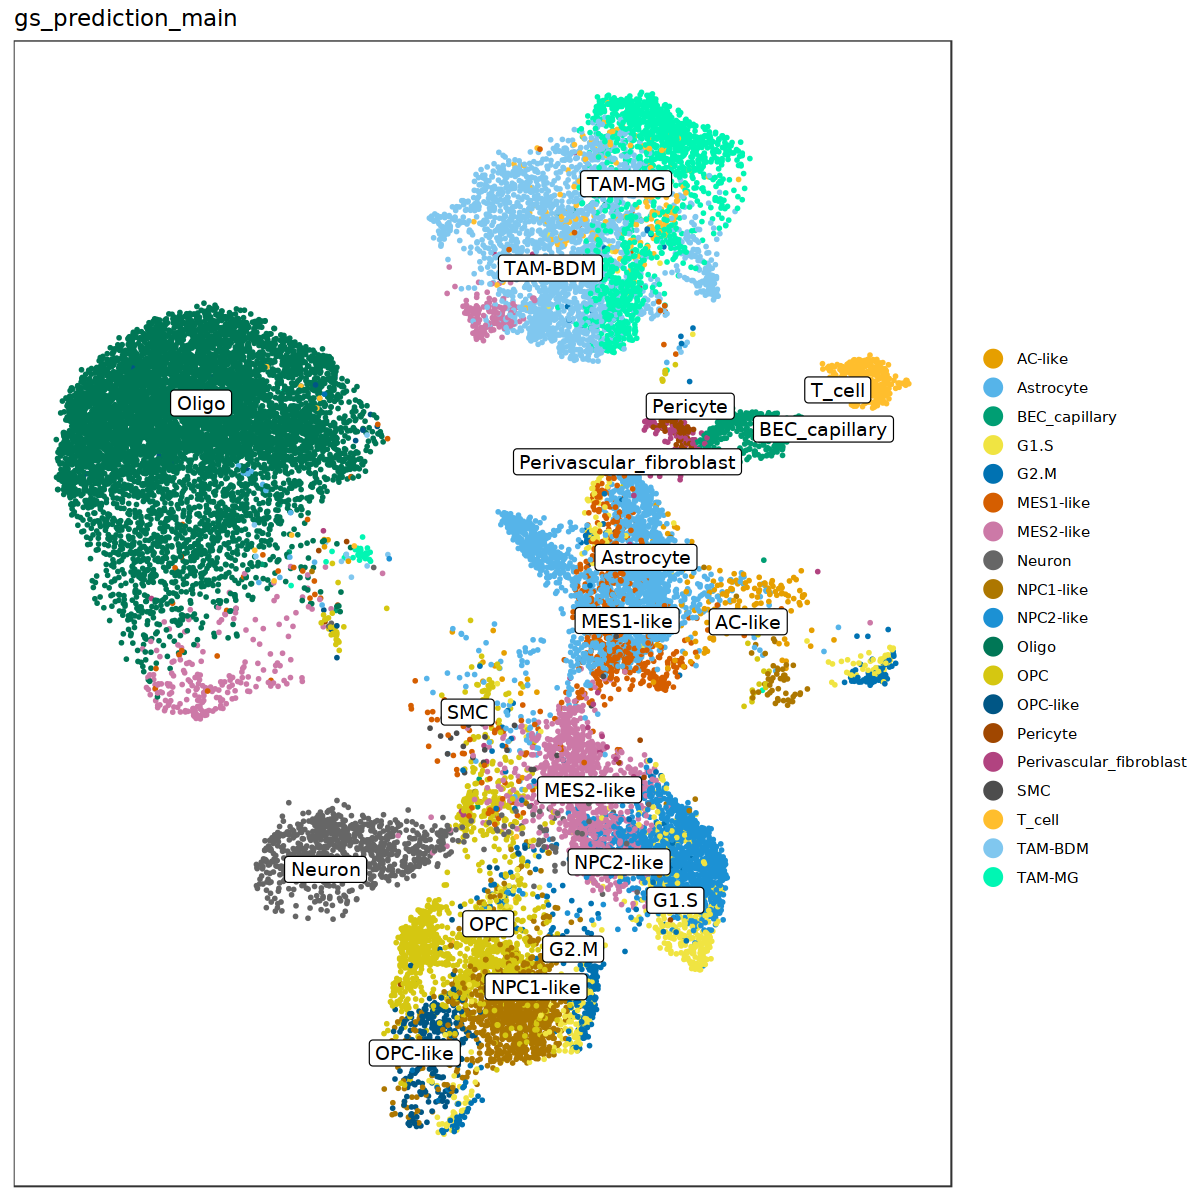

In [ ]:
options(repr.plot.height = 10, repr.plot.width = 10)
dittoDimPlot(subset(gbm, subset = gs_prediction_main == 'unassigned', invert = TRUE), 
             reduction.use = "umap", var = "gs_prediction", # this comes from the automated annotation with CellID
             # see 02_automated_cell_annotation_with_cellID.ipynb
                       do.label = T, labels.size = 4) + NoAxes() 

In [ ]:
# source https://www.ncbi.nlm.nih.gov/pubmed/31327527
signatures <- as.data.frame(data.table::fread(paste0('/hpc/pmc_stunnenberg/cruiz/scRNA/markers-and-databases/',
                                'GBM_public-data/Neftel2019/IDHwt.GBM.MetaModules.tsv')))

colnames(signatures)[colnames(signatures) == 'G1/S'] <- 'G1.S'
colnames(signatures)[colnames(signatures) == 'G2/M'] <- 'G2.M'

signatures

signatures.list <- list()

for(i in 1:length(colnames(signatures))){
  gene.names <- as.data.table(checkGeneSymbols(na.omit(signatures[[i]]), unmapped.as.na=FALSE))
  signatures.list <- append(signatures.list, list(gene.names$Suggested.Symbol))
}

names(signatures.list) <- colnames(signatures)

signatures.list

MESlike2,MESlike1,AClike,OPClike,NPClike1,NPClike2,G1.S,G2.M
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
HILPDA,CHI3L1,CST3,BCAN,DLL3,STMN2,RRM2,CCNB1
ADM,ANXA2,S100B,PLP1,DLL1,CD24,PCNA,CDC20
DDIT3,ANXA1,SLC1A3,GPR17,SOX4,RND3,KIAA0101,CCNB2
NDRG1,CD44,HEPN1,FIBIN,TUBB3,HMP19,HIST1H4C,PLK1
HERPUD1,VIM,HOPX,LHFPL3,HES6,TUBB3,MLF1IP,CCNA2
DNAJB9,MT2A,MT3,OLIG1,TAGLN3,MIAT,GMNN,CKAP2
TRIB3,C1S,SPARCL1,PSAT1,NEU4,DCX,RNASEH2A,KNSTRN
ENO2,NAMPT,MLC1,SCRG1,MARCKSL1,NSG1,MELK,RACGAP1
AKAP12,EFEMP1,GFAP,OMG,CD24,ELAVL4,CENPK,CDCA3


Maps last updated on: Thu Mar 25 08:36:49 2021

Warning message in checkGeneSymbols(na.omit(signatures[[i]]), unmapped.as.na = FALSE):
“x contains non-approved gene symbols”
Maps last updated on: Thu Mar 25 08:36:49 2021

Warning message in checkGeneSymbols(na.omit(signatures[[i]]), unmapped.as.na = FALSE):
“x contains non-approved gene symbols”
Maps last updated on: Thu Mar 25 08:36:49 2021

Warning message in checkGeneSymbols(na.omit(signatures[[i]]), unmapped.as.na = FALSE):
“x contains non-approved gene symbols”
Maps last updated on: Thu Mar 25 08:36:49 2021

Warning message in checkGeneSymbols(na.omit(signatures[[i]]), unmapped.as.na = FALSE):
“x contains non-approved gene symbols”
Maps last updated on: Thu Mar 25 08:36:49 2021

Warning message in checkGeneSymbols(na.omit(signatures[[i]]), unmapped.as.na = FALSE):
“x contains non-approved gene symbols”
Maps last updated on: Thu Mar 25 08:36:49 2021

Warning message in checkGeneSymbols(na.omit(signatures[[i]]), unmapped.as.na = FAL

$MESlike2
 [1] "HILPDA"   "ADM"      "DDIT3"    "NDRG1"    "HERPUD1"  "DNAJB9"  
 [7] "TRIB3"    "ENO2"     "AKAP12"   "SQSTM1"   "MT1X"     "ATF3"    
[13] "NAMPT"    "NRN1"     "SLC2A1"   "BNIP3"    "LGALS3"   "INSIG2"  
[19] "IGFBP3"   "PPP1R15A" "VIM"      "PLOD2"    "GBE1"     "SLC2A3"  
[25] "FTL"      "WARS1"    "ERO1A"    "XPOT"     "HSPA5"    "GDF15"   
[31] "ANXA2"    "EPAS1"    "LDHA"     "P4HA1"    "SERTAD1"  "PFKP"    
[37] "PGK1"     "EGLN3"    "SLC6A6"   "CA9"      "BNIP3L"   "RPL21"   
[43] "TRAM1"    "UFM1"     "ASNS"     "GOLT1B"   "ANGPTL4"  "SLC39A14"
[49] "CDKN1A"   "HSPA9"   

$MESlike1
 [1] "CHI3L1"   "ANXA2"    "ANXA1"    "CD44"     "VIM"      "MT2A"    
 [7] "C1S"      "NAMPT"    "EFEMP1"   "C1R"      "SOD2"     "IFITM3"  
[13] "TIMP1"    "SPP1"     "A2M"      "S100A11"  "MT1X"     "S100A10" 
[19] "FN1"      "LGALS1"   "S100A16"  "CLIC1"    "MGST1"    "RCAN1"   
[25] "TAGLN2"   "NPC2"     "SERPING1" "TCIM"     "EMP1"     "APOE"    
[31] "CTSB"     "C3"       "LGALS3"   "MT1E"     "EMP3"     "SERPINA3"
[37] "ACTN1"    "PRDX6"    "IGFBP7"   "SERPINE1" "PLP2"     "MGP"     
[43] "CLIC4"    "GFPT2"    "GSN"      "NNMT"     "TUBA1C"   "GJA1"    
[49] "TNFRSF1A" "WWTR1"   

$AClike
 [1] "CST3"    "S100B"   "SLC1A3"  "HEPN1"   "HOPX"    "MT3"     "SPARCL1"
 [8] "MLC1"    "GFAP"    "FABP7"   "BCAN"    "PON2"    "METTL7B" "SPARC"  
[15] "GATM"    "RAMP1"   "PMP2"    "AQP4"    "DBI"     "EDNRB"   "PTPRZ1" 
[22] "CLU"     "PMP22"   "ATP1A2"  "S100A16" "HEY1"    "PCDHGC3" "TTYH1"  
[29] "NDRG2"   "PRCP"    "ATP1B2"  "AGT"     "PLTP"    "GPM6B"   "F3"     
[36] "RAB31"   "PLPP3"   "ANXA5"   "TSPAN7" 

$OPClike
 [1] "BCAN"    "PLP1"    "GPR17"   "FIBIN"   "LHFPL3"  "OLIG1"   "PSAT1"  
 [8] "SCRG1"   "OMG"     "APOD"    "SIRT2"   "TNR"     "THY1"    "PHYHIPL"
[15] "SOX2-OT" "NKAIN4"  "PLPPR1"  "PTPRZ1"  "VCAN"    "DBI"     "PMP2"   
[22] "CNP"     "TNS3"    "LIMA1"   "CA10"    "PCDHGC3" "CNTN1"   "SCD5"   
[29] "P2RX7"   "CADM2"   "TTYH1"   "FGF12"   "PACC1"   "NEU4"    "FXYD6"  
[36] "RNF13"   "RTKN"    "GPM6B"   "LMF1"    "ALCAM"   "PGRMC1"  "PLAAT1" 
[43] "BCAS1"   "RAB31"   "PLLP"    "FABP5"   "NLGN3"   "SERINC5" "EPB41L2"
[50] "GPR37L1"

$NPClike1
 [1] "DLL3"     "DLL1"     "SOX4"     "TUBB3"    "HES6"     "TAGLN3"  
 [7] "NEU4"     "MARCKSL1" "CD24"     "STMN1"    "TCF12"    "BEX1"    
[13] "OLIG1"    "MAP2"     "FXYD6"    "PTPRS"    "MLLT11"   "NPPA"    
[19] "BCAN"     "MEST"     "ASCL1"    "BTG2"     "DCX"      "NXPH1"   
[25] "JPT1"     "PFN2"     "SCG3"     "MYT1"     "CHD7"     "ADGRG1"  
[31] "TUBA1A"   "PCBP4"    "ETV1"     "SHD"      "TNR"      "AMOTL2"  
[37] "DBN1"     "HIP1"     "ABAT"     "ELAVL4"   "LMF1"     "GRIK2"   
[43] "SERINC5"  "TSPAN13"  "ELMO1"    "GLCCI1"   "SEZ6L"    "LRRN1"   
[49] "SEZ6"     "SOX11"   

$NPClike2
 [1] "STMN2"        "CD24"         "RND3"         "NSG2"         "TUBB3"       
 [6] "MIAT"         "DCX"          "NSG1"         "ELAVL4"       "MLLT11"      
[11] "DLX6-AS1"     "SOX11"        "NREP"         "FNBP1L"       "TAGLN3"      
[16] "STMN4"        "DLX5"         "SOX4"         "MAP1B"        "RBFOX2"      
[21] "IGFBPL1"      "STMN1"        "JPT1"         "TMEM161B-AS1" "DPYSL3"      
[26] "SEPTIN3"      "PKIA"         "ATP1B1"       "DYNC1I1"      "CD200"       
[31] "SNAP25"       "PAK3"         "NDRG4"        "KIF5A"        "UCHL1"       
[36] "ENO2"         "KIF5C"        "DDAH2"        "TUBB2A"       "LBH"         
[41] "LOC150568"    "TCF4"         "GNG3"         "NFIB"         "DPYSL5"      
[46] "CRABP1"       "DBN1"         "NFIX"         "CEP170"       "BLCAP"       

$G1.S
 [1] "RRM2"     "PCNA"     "PCLAF"    "H4C3"     "CENPU"    "GMNN"    
 [7] "RNASEH2A" "MELK"     "CENPK"    "TK1"      "TMEM106C" "CDCA5"   
[13] "CKS1B"    "CDC45"    "MCM3"     "CENPM"    "AURKB"    "PKMYT1"  
[19] "MCM4"     "ASF1B"    "GINS2"    "MCM2"     "FEN1"     "RRM1"    
[25] "DUT"      "RAD51AP1" "MCM7"     "CCNE2"    "ZWINT"   

$G2.M
 [1] "CCNB1"     "CDC20"     "CCNB2

Warning message:
“The following features are not present in the object: SERPINA3, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: PCDHGC3, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: SOX2-OT, PCDHGC3, FXYD6, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FXYD6, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: LOC150568, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FEN1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: ARL6IP1, SPAG5, not searching for symbol synonyms”


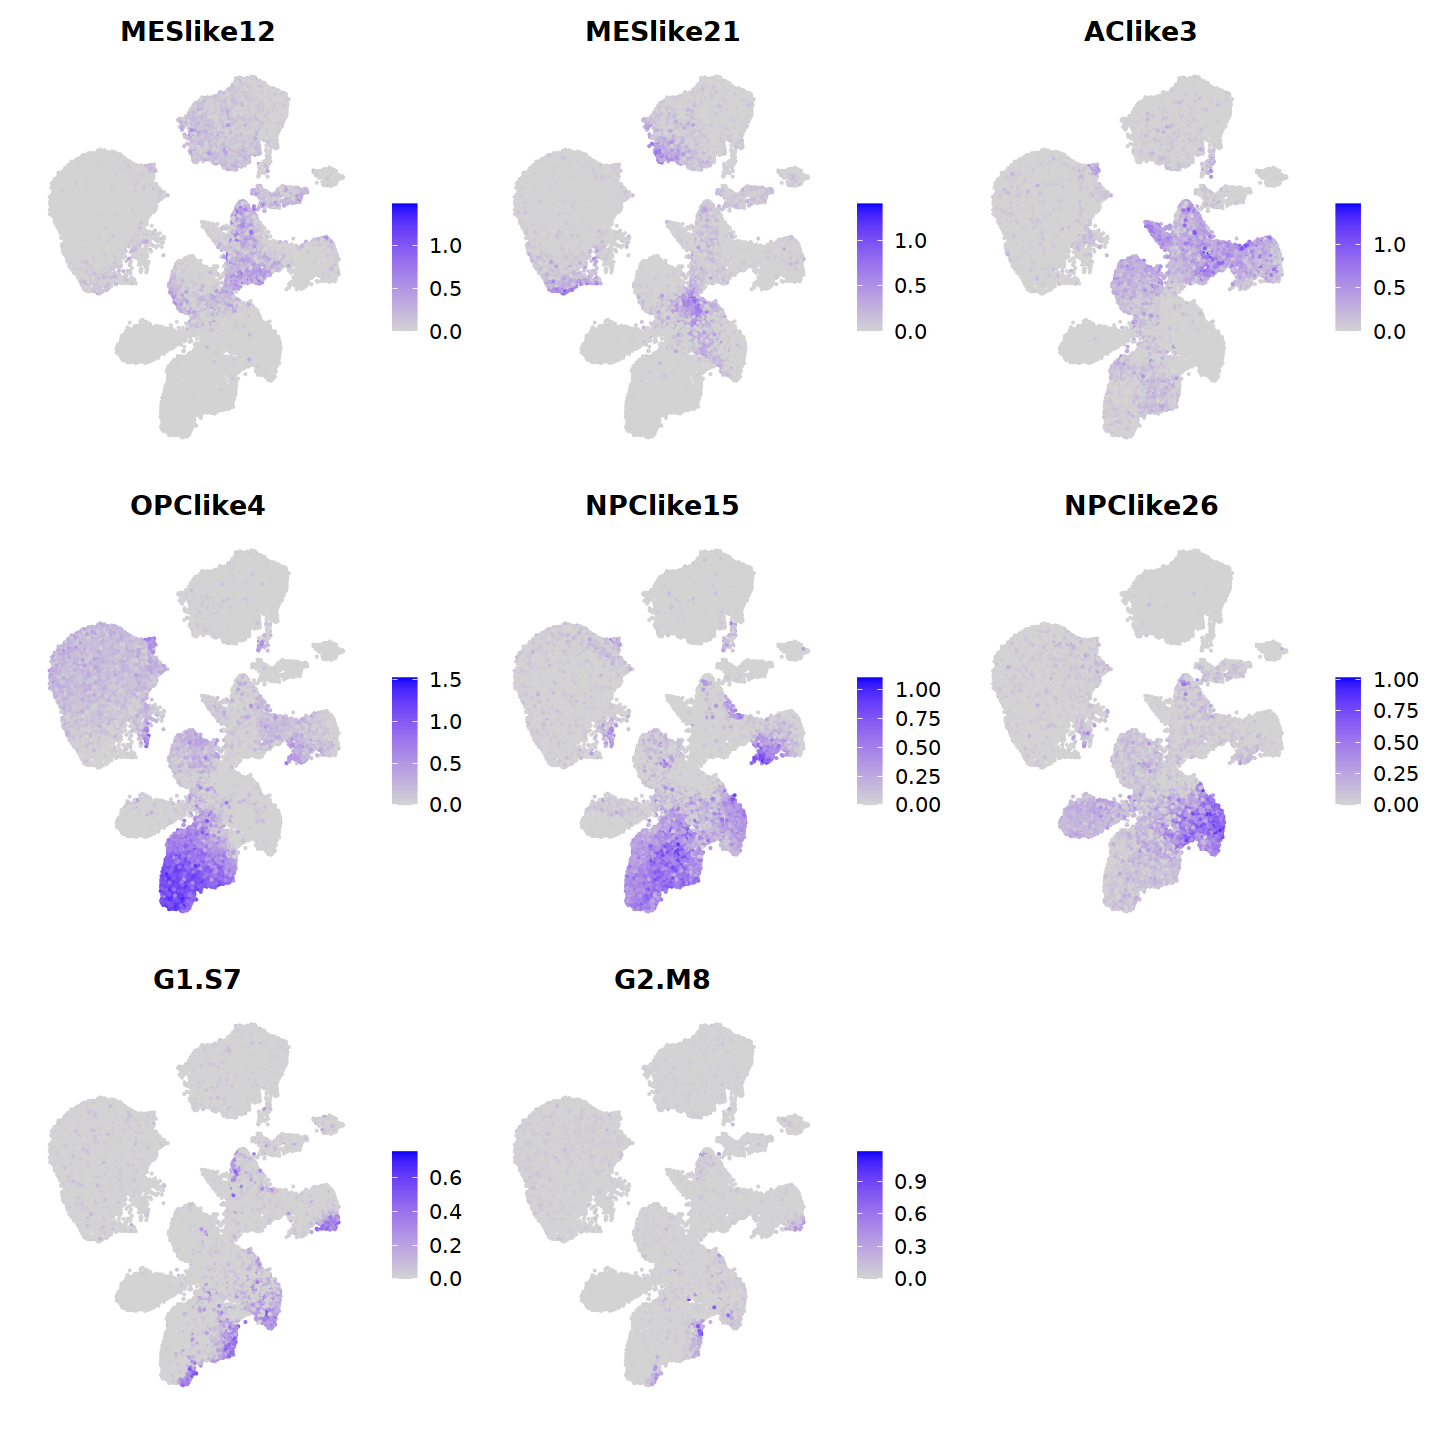

In [ ]:
gbm <- AddModuleScore(object = gbm,
                      features =signatures.list,
                      name = names(signatures.list)
                                      )
options(repr.plot.height = 12, repr.plot.width = 12)
FeaturePlot(gbm, 
            c('MESlike12', 'MESlike21', 'AClike3','OPClike4',
              'NPClike15','NPClike26','G1.S7','G2.M8'), 
            min.cutoff = 0, pt.size = 0.1) & NoAxes()

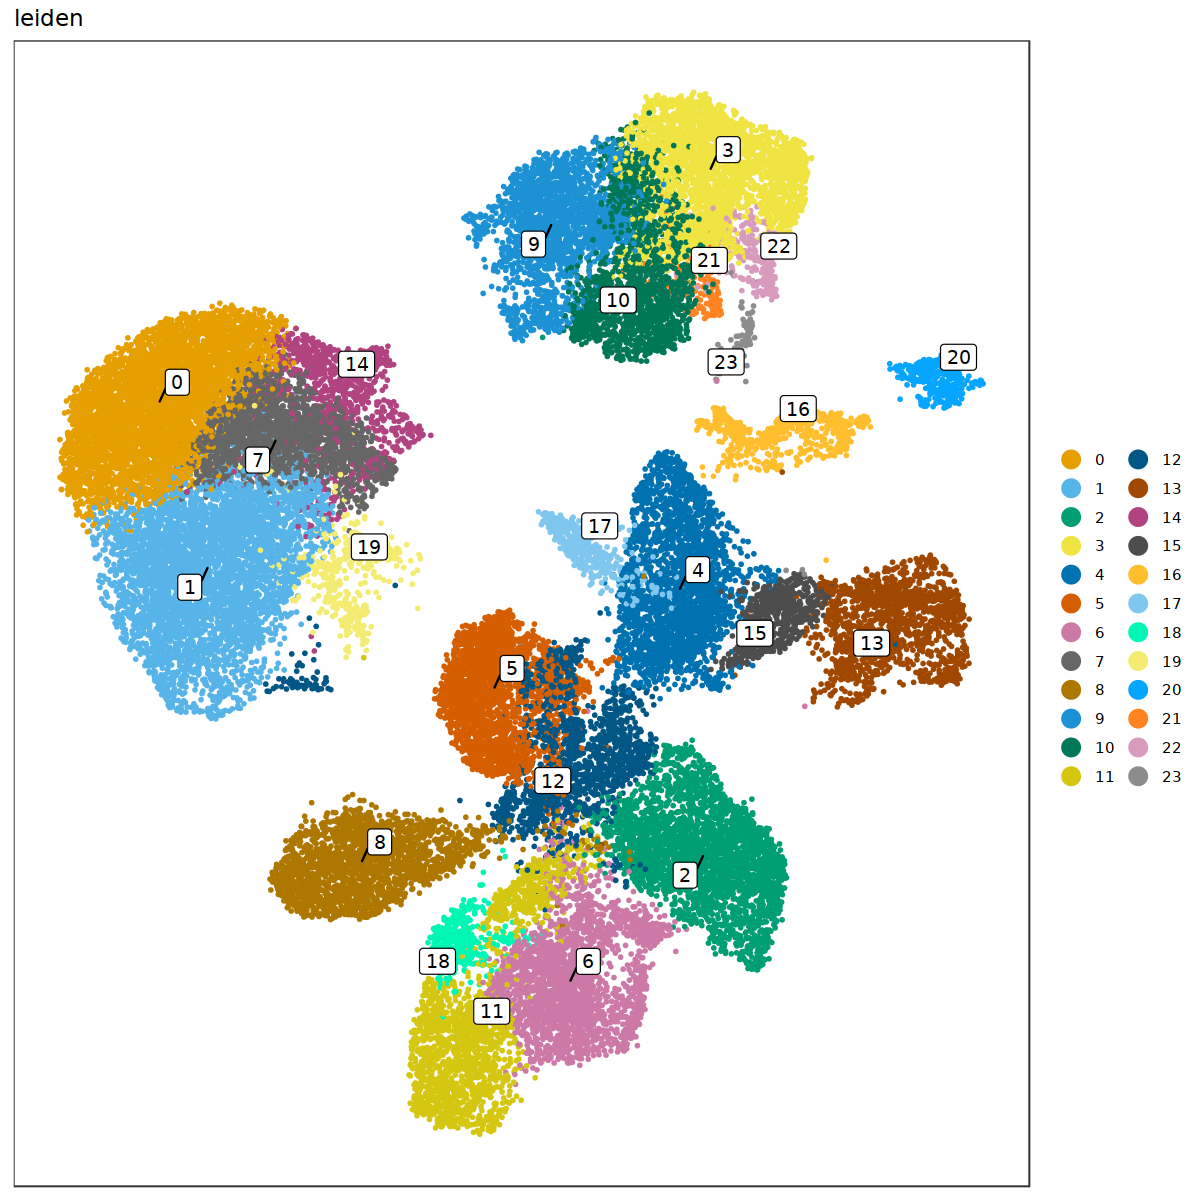

In [ ]:
gbm <- AddMetaData(gbm, gbm_latent$obs['leiden'] %>% `rownames<-` (colnames(gbm)))

options(repr.plot.height = 10, repr.plot.width = 10)
dittoDimPlot(gbm, 
             reduction.use = "umap", var = "leiden", 
             do.label = T, labels.size = 4) + NoAxes() 

In [ ]:
Idents(gbm) <- gbm@meta.data$`leiden`
markers <- FindAllMarkers(gbm, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23



For cell annotation, we considered the results from the automatic cell annotation <br>
and the expression of cell type-specific marker genes identified using the Wilcoxon rank-sum test <br>
by comparing all cells within a specific cluster to all cells outside said cluster. 

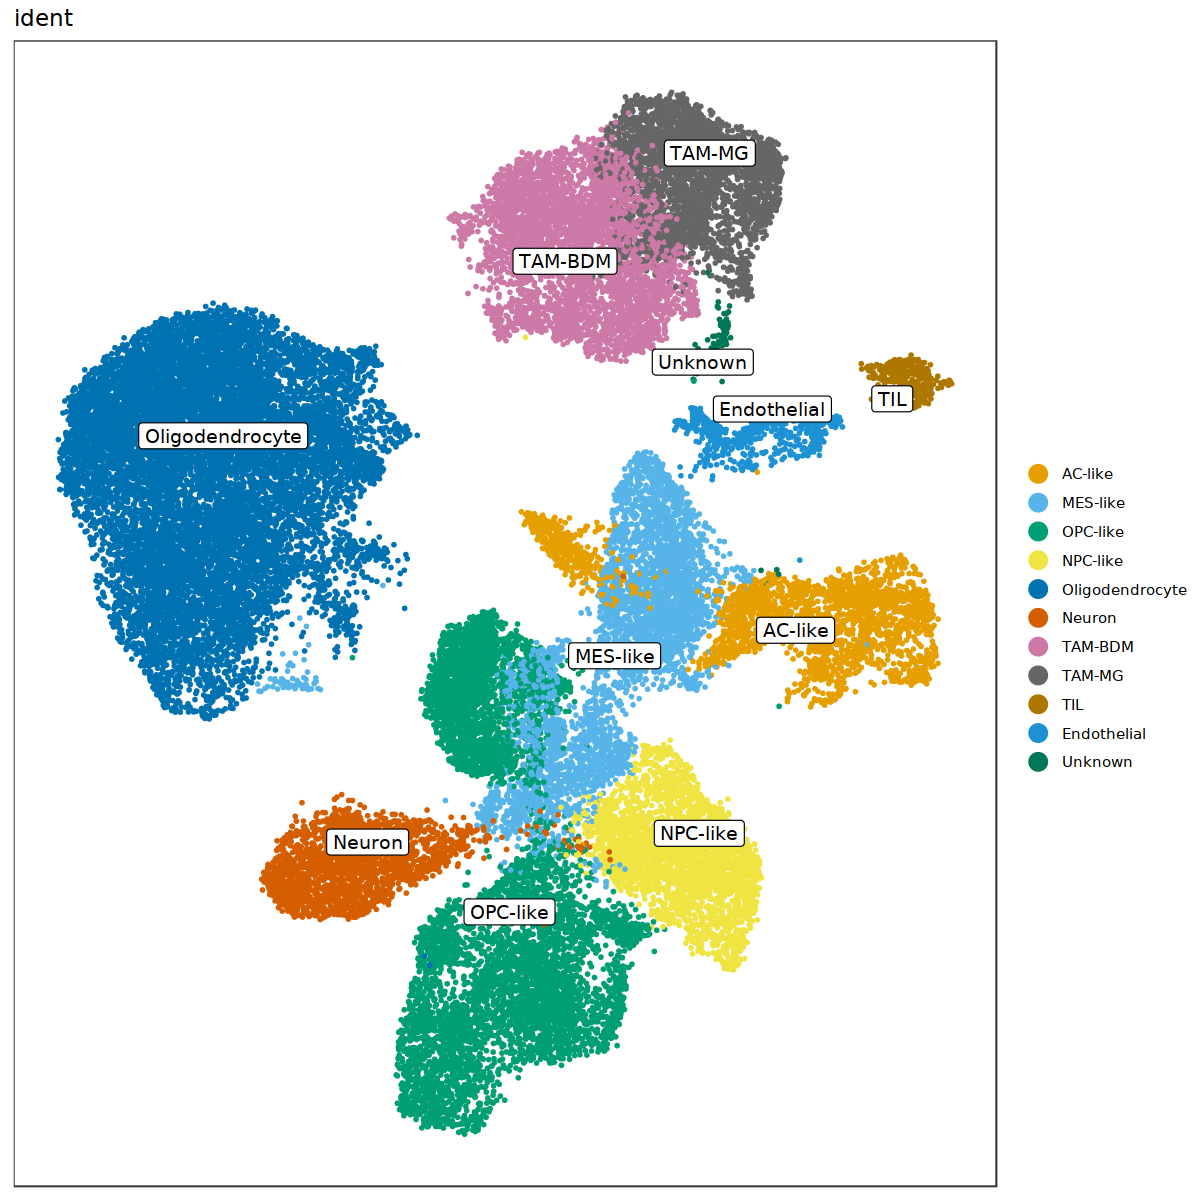

In [ ]:
Idents(gbm) <- gbm@meta.data$`leiden`

gbm <- RenameIdents(gbm, `0` = "Oligodendrocyte",
                    `1` = "Oligodendrocyte",
                    `2` = "NPC-like", 
                    `3` = "TAM-MG", 
                    `4` = "MES-like", 
                    `5` = "OPC-like", 
                    `6` = "OPC-like", 
                    `7` = "Oligodendrocyte", 
                    `8` = "Neuron", 
                    `9` = "TAM-BDM",
                    `10` = "TAM-BDM",
                    `11` = "OPC-like", 
                    `12` = "MES-like", 
                    `13` = "AC-like", 
                    `14` = "Oligodendrocyte",
                    `15` = "AC-like",
                    `16` = "Endothelial", 
                    `17` = "AC-like", 
                    `18` = "OPC-like", 
                    `19` = "Oligodendrocyte", 
                    `20` = "TIL", 
                    `21` = "TAM-BDM", 
                    `22` = "TAM-MG", 
                    `23` = "Unknown"
                    )

gbm@active.ident <- factor(x = gbm@active.ident, 
                                   levels = c('AC-like','MES-like','OPC-like','NPC-like',
     'Oligodendrocyte','Neuron',
     'TAM-BDM','TAM-MG',
     'TIL',
     'Endothelial', 'Unknown'))

options(repr.plot.height = 10, repr.plot.width = 10)
dittoDimPlot(gbm, 
             reduction.use = "umap", var = "ident", 
             do.label = T, labels.size = 4) + NoAxes() 

In [ ]:
saveRDS('data/Ruiz2021_manual_annotation.rds')